In [49]:
import Pkg; 

In [50]:
using Pkg, DifferentialEquations, PenaltyFunctions, Optim, StatsBase, Plots, CSV, DataFrames, DiffEqParamEstim;

# Exponential growth (individual)

In [51]:
# exponential growth of a single population
#u is the population and p is the parameter
function singleExpGrowth(du,u,p,t)
    du[1] = p[1].*u[1]
end

singleExpGrowth (generic function with 1 method)

In [52]:
# set initial conditions
param = [0.3]
u0 = [12000];
tspan = (0.0, 10.0);

# define ODE problem & solve
prob = ODEProblem(singleExpGrowth,u0,tspan,param);
#sol=solve(prob)
sol = solve(prob); #have one time point per day within the 10 days

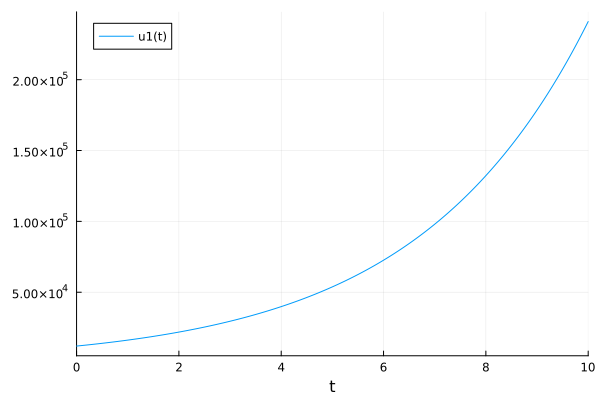

In [53]:
plot(sol)

# Setting up parameter estimation (AIC)

In [54]:
function calcAICscore(RSS,n,k)
    AIC = 2.0*(k+1)+n+log(RSS/n)+n*(1+log(2*pi))
end

calcAICscore (generic function with 1 method)

# Load data T sensitive

In [55]:
#import data
t1="C:\\Users\\adelpinoherrera\\Dropbox (UFL)\\research-share\\Adriana\\Pt-resistant Ovarian Cancer\\Code\\Pop dynamics T cells\\tyk-nu.csv"
t=CSV.read(t1,DataFrame)
data_t=Matrix(t)

3×11 Matrix{Float64}:
 12000.0  27636.4  30099.6  76600.8  …  3.85157e5  4.1024e5   3.7234e5
 12000.0  23230.6  34545.5  70442.7     2.92535e5  4.15096e5  3.06353e5
 12000.0  24512.3  27936.8  54872.2     3.51813e5  4.05584e5  3.17117e5

In [56]:
timepts = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0];
repli1_t=data_t[1,:];
repli2_t=data_t[2,:];
repli3_t=data_t[3,:];

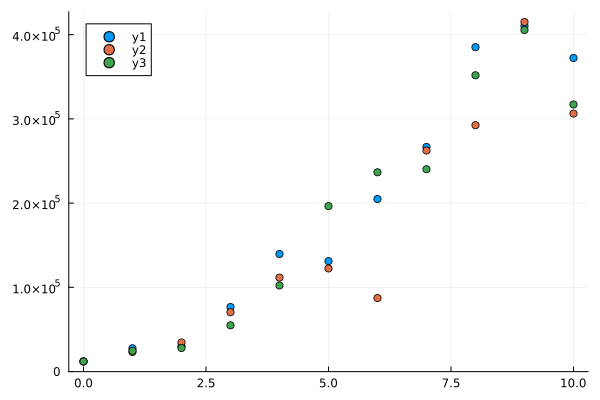

In [57]:
scatter(timepts,repli1_t)
scatter!(timepts,repli2_t)
scatter!(timepts, repli3_t)

# Build Loss Function

In [58]:
#function to calculate the loss: loss(solve(diffeq), data)
function my_loss_func(sol)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol.u))
      tot_loss = Inf
    else
        # calculation for the loss here
        for i in 1:length(sol.u)#before size(data)[1] #length(sol.u)
            solI = sol.u[i]
            x = data_t[i,(2:end)]
            y = [solI(1)[1],solI(2)[1],solI(3)[1],solI(4)[1],solI(5)[1],solI(6)[1],solI(7)[1],solI(8)[1],solI(9)[1],solI(10)[1]]
            tot_loss += sum(((x .- y).^2)./((x).^2))
        end
    end
    tot_loss
end   

my_loss_func (generic function with 1 method)

# Building Ensemble Problem for Solving ODE with Differential Initial Conditions

In [59]:
# create initial condition array to pull from
N = size(data_t,1);
initial_conditions = Array{Any}(undef,N,1);
for i=1:N
   initial_conditions[i] = [Float64(data_t[i,1])];
end

In [60]:
# create function that makes that defines the ODE problem with the different initial conditions pulled from data

function prob_func(prob,i,repeat)
  ODEProblem(prob.f,initial_conditions[i],prob.tspan,prob.p);
end

prob_func (generic function with 1 method)

In [61]:
# build & solve the Ensemble problem 
#     number of trajectories are the number of different initial conditions

monte_prob = EnsembleProblem(prob,prob_func=prob_func);
sim = solve(monte_prob, Rodas5(), EnsembleDistributed(), trajectories = size(initial_conditions)[1]); #saveat=1);

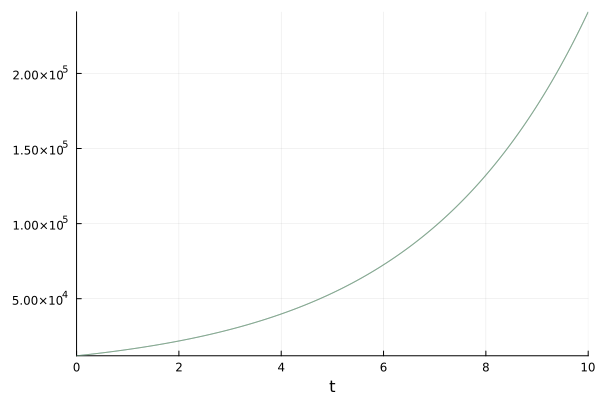

In [62]:
plot(sim,linealpha=0.4)

In [63]:
err = my_loss_func(sim)

8.423355863112699

# Build Regularized Loss Function

In [198]:
# Build regularized loss function

prob = ODEProblem(singleExpGrowth,u0,tspan,param);

function build_regularized_loss_func(λ)

    function regularized_loss_func(odeparams) 
        
        function prob_func(prob,i,repeat)
            ODEProblem(prob.f,initial_conditions[i],prob.tspan,odeparams);
        end
        
        monte_prob = EnsembleProblem(prob,prob_func=prob_func);
        
        sim = solve(monte_prob, 
            Rosenbrock23(autodiff=false),
            EnsembleDistributed(), 
            trajectories = size(initial_conditions)[1]
        );
        
        return my_loss_func(sim) + λ*sum(abs.(odeparams));
    end
    
    return regularized_loss_func;
end

build_regularized_loss_func (generic function with 1 method)

# Run Optimization 

In [65]:
result = @time Optim.optimize(build_regularized_loss_func(0),
    [-2.0], [2.0], ## upper and lower bounds 
    param, 
    Fminbox(LBFGS()),
    Optim.Options(f_tol=0.0, g_tol=1e-16, allow_f_increases=true, iterations=100000))

2630.103408 seconds (5.86 G allocations: 338.687 GiB, 4.71% gc time, 0.07% compilation time: 7% of which was recompilation)


 * Status: success

 * Candidate solution
    Final objective value:     4.729594e+00

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.93e-04 ≰ 1.0e-16

 * Work counters
    Seconds run:   2630  (vs limit Inf)
    Iterations:    26
    f(x) calls:    2018756
    ∇f(x) calls:   2018756


In [66]:
paramFIT = result.minimizer

1-element Vector{Float64}:
 0.372572604404757

In [67]:
paramFitErr = result.minimum     

4.729593684337386

In [68]:
println("AIC of Exponential Fit: ", calcAICscore(paramFitErr,size(data_t)[1],1))

AIC of Exponential Fit: 15.968858207542576


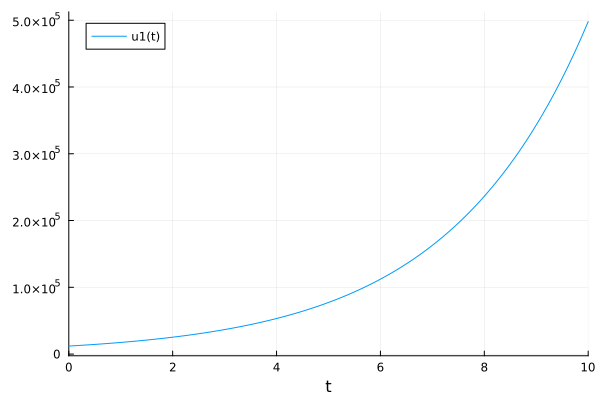

In [69]:
problem = ODEProblem(singleExpGrowth,u0,tspan,paramFIT)
simFit = solve(problem,Vern8());
plot(simFit)

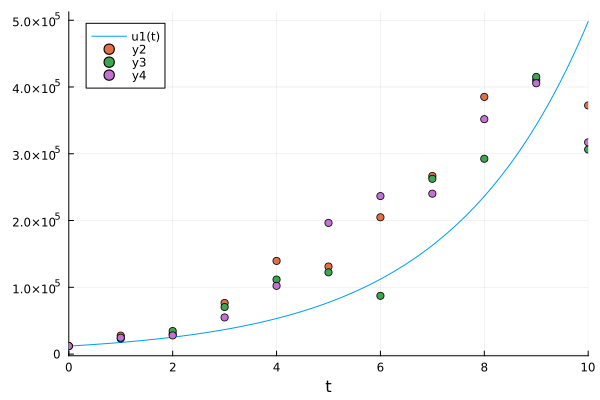

In [70]:
scatter!(timepts,repli1_t)
scatter!(timepts,repli2_t)
scatter!(timepts, repli3_t)

In [71]:
#export estimated curve to csv file
exp_t = "C:/Users/adelpinoherrera/Dropbox (UFL)/research-share/Adriana/Pt-resistant Ovarian Cancer/Code/Pop dynamics T cells/est_exp_t.csv"
CSV.write(exp_t,simFit)

"C:/Users/adelpinoherrera/Dropbox (UFL)/research-share/Adriana/Pt-resistant Ovarian Cancer/Code/Pop dynamics T cells/est_exp_t.csv"

Logistic Growth

In [72]:
# logistic growth of a single population with carrying capacity
function singleLogGrowth(du,u,p,t)
    du[1] = p[1].*u[1].*(1-(u[1]./p[2]))
end

singleLogGrowth (generic function with 1 method)

In [73]:
prob = ODEProblem(singleLogGrowth, u0, tspan, [0.5,500000.0]);

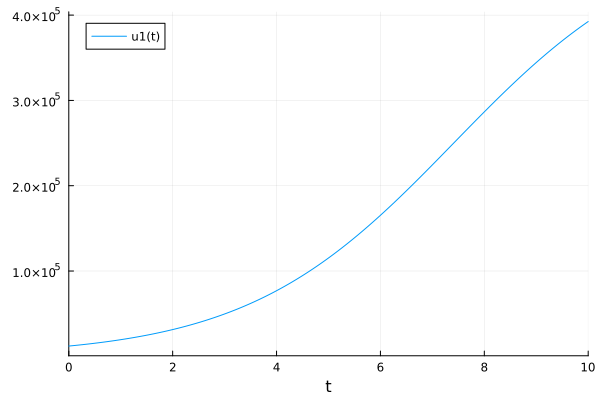

In [74]:
sol = solve(prob); 
plot(sol)

In [75]:
result2 = @time Optim.optimize(build_regularized_loss_func(0),
    [0.0, 2.0], #upper and lower bounds for the optimization variables
    [5.0, 1000000.0], ## bounds on constrains
    [0.01,10.0], #initial values for optimization variables 
    Fminbox(LBFGS()),
    Optim.Options(f_tol=0.0, g_tol=1e-16, allow_f_increases=true, iterations=100000))

 18.611823 seconds (59.00 M allocations: 3.411 GiB, 5.56% gc time, 2.91% compilation time: 17% of which was recompilation)


 * Status: success

 * Candidate solution
    Final objective value:     2.146808e+00

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 9.06e-07 ≰ 1.0e-16

 * Work counters
    Seconds run:   19  (vs limit Inf)
    Iterations:    5
    f(x) calls:    11720
    ∇f(x) calls:   11720


In [76]:
paramFIT2 = result2.minimizer

2-element Vector{Float64}:
      0.5330178082627773
 417791.132166636

In [77]:
paramFitErr2 = result2.minimum

2.146808022025945

In [78]:
println("AIC of Logistic Fit: ", calcAICscore(paramFitErr2,size(data_t)[1],2))

AIC of Logistic Fit: 17.179001008609994


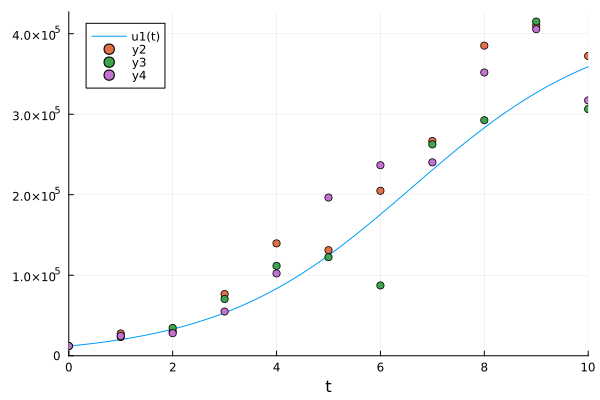

In [79]:
problem2 = ODEProblem(singleLogGrowth,u0,tspan,paramFIT2)
simFit2 = solve(problem2,Vern8());
plot(simFit2)
scatter!(timepts,repli1_t)
scatter!(timepts,repli2_t)
scatter!(timepts, repli3_t)

In [80]:
#export estimated curve to csv file
log_t = "C:/Users/adelpinoherrera/Dropbox (UFL)/research-share/Adriana/Pt-resistant Ovarian Cancer/Code/Pop dynamics T cells/est_log_t.csv"
CSV.write(log_t,simFit2)

"C:/Users/adelpinoherrera/Dropbox (UFL)/research-share/Adriana/Pt-resistant Ovarian Cancer/Code/Pop dynamics T cells/est_log_t.csv"

Gompertz growth

In [81]:
# gompertz growth of a single population with carrying capacity
function singleGompGrowth(du,u,p,t)
    du[1] = p[1].*log(p[2]./u[1]).*u[1] #Maxi
end

singleGompGrowth (generic function with 1 method)

In [171]:
prob = ODEProblem(singleGompGrowth, u0, tspan, [0.5,5000000.0]);

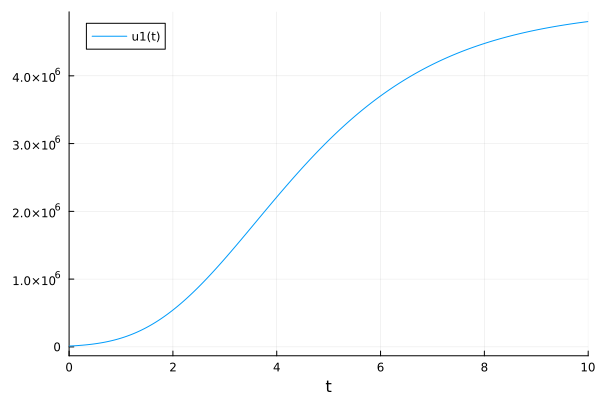

In [172]:
sol = solve(prob); 
plot(sol)

In [84]:
result3 = @time Optim.optimize(build_regularized_loss_func(0),
    [0.0, 2.0], #upper and lower bounds for the optimization variables
    [5.0, 1000000.0], ## bounds on constrains
    [0.01,10.0], #initial values for optimization variables 
    Fminbox(LBFGS()),
    Optim.Options(f_tol=0.0, g_tol=1e-16, allow_f_increases=true, iterations=100000))

 38.178667 seconds (103.02 M allocations: 5.966 GiB, 4.96% gc time, 2.05% compilation time)


 * Status: success

 * Candidate solution
    Final objective value:     2.086862e+00

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.02e-06 ≰ 1.0e-16

 * Work counters
    Seconds run:   38  (vs limit Inf)
    Iterations:    23
    f(x) calls:    21295
    ∇f(x) calls:   21295


In [85]:
paramFIT3 = result3.minimizer

2-element Vector{Float64}:
      0.15021256365746344
 999999.9999999999

In [86]:
paramFitErr3 = result3.minimum

2.0868623601308416

In [87]:
println("AIC of Logistic Fit: ", calcAICscore(paramFitErr3,size(data_t)[1],2))

AIC of Logistic Fit: 17.1506805854168


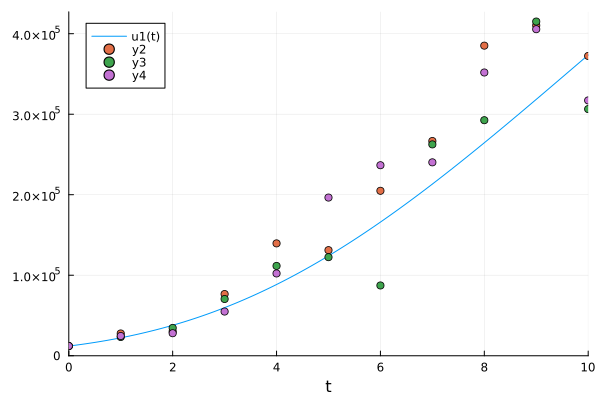

In [88]:
problem3 = ODEProblem(singleGompGrowth,u0,tspan,paramFIT3)
simFit3 = solve(problem3,Vern8());
plot(simFit3)
scatter!(timepts,repli1_t)
scatter!(timepts,repli2_t)
scatter!(timepts, repli3_t)

In [89]:
#export estimated curve to csv file
gomp_t = "C:/Users/adelpinoherrera/Dropbox (UFL)/research-share/Adriana/Pt-resistant Ovarian Cancer/Code/Pop dynamics T cells/est_gomp_t.csv"
CSV.write(gomp_t,simFit3)

"C:/Users/adelpinoherrera/Dropbox (UFL)/research-share/Adriana/Pt-resistant Ovarian Cancer/Code/Pop dynamics T cells/est_gomp_t.csv"

Von Bertalanffy growth 

In [146]:
# von bertalanffy growth of a single population assuming sphere
function singleBertGrowth(du,u,p,t)
    du[1] = p[1].*(u[1].^(2/3)) #maxi
    #du[1] = p[1].*(u[1].^(2/3)) - p[2].*u[1]
end

singleBertGrowth (generic function with 1 method)

In [163]:
prob = ODEProblem(singleBertGrowth, u0, tspan, [20]);

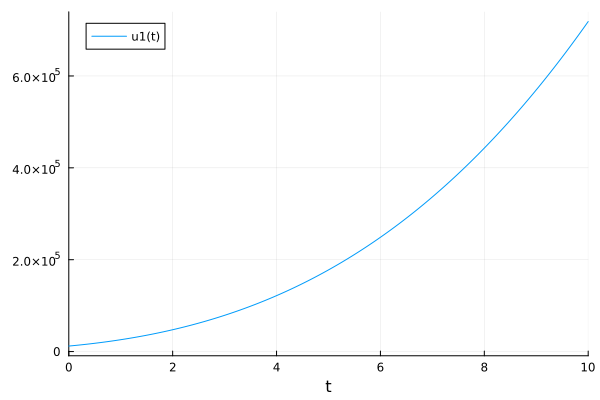

In [164]:
sol = solve(prob); 
plot(sol)

In [165]:
result4 = @time Optim.optimize(build_regularized_loss_func(0),
    [0.0], [25.0],
    param,
    Fminbox(LBFGS()),
    Optim.Options(f_tol=0.0, g_tol=1e-16, allow_f_increases=true, iterations=100000))

  1.175755 seconds (3.88 M allocations: 229.722 MiB, 7.80% gc time)


 * Status: success

 * Candidate solution
    Final objective value:     2.186204e+00

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 1.42e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.13e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.93e-09 ≰ 1.0e-16

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    5
    f(x) calls:    1362
    ∇f(x) calls:   1362


In [166]:
paramFIT4 = result4.minimizer

1-element Vector{Float64}:
 15.52340251471659

In [167]:
paramFitErr4 = result4.minimum

2.186204468608087

In [168]:
println("AIC of Logistic Fit: ", calcAICscore(paramFitErr4,size(data_t)[1],1))

AIC of Logistic Fit: 15.197185831442429


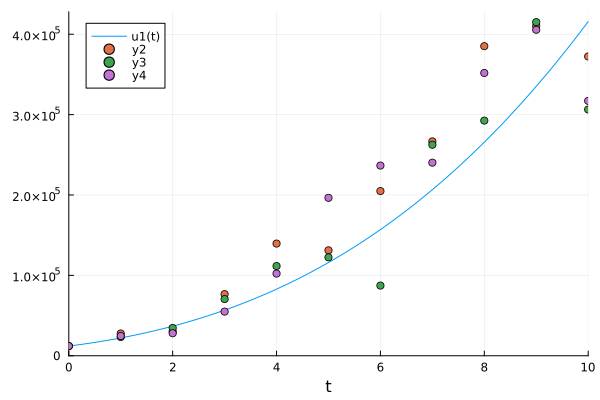

In [169]:
problem4 = ODEProblem(singleBertGrowth,u0,tspan,paramFIT4)
simFit4 = solve(problem4,Vern8());
plot(simFit4)
scatter!(timepts,repli1_t)
scatter!(timepts,repli2_t)
scatter!(timepts, repli3_t)

In [170]:
#export estimated curve to csv file
berta_t = "C:/Users/adelpinoherrera/Dropbox (UFL)/research-share/Adriana/Pt-resistant Ovarian Cancer/Code/Pop dynamics T cells/est_berta_t.csv"
CSV.write(berta_t,simFit4)

"C:/Users/adelpinoherrera/Dropbox (UFL)/research-share/Adriana/Pt-resistant Ovarian Cancer/Code/Pop dynamics T cells/est_berta_t.csv"

Generalized logistic growth

In [199]:
# generalized logistic growth of a single population with carrying capacity
function singleGenLogGrowth(du,u,p,t)
    du[1] = p[1].*u[1].*(1-(u[1]./p[2]).^p[3])
end

singleGenLogGrowth (generic function with 1 method)

In [200]:
prob = ODEProblem(singleGenLogGrowth, u0, tspan, [0.8,5000000.0,1.5]);

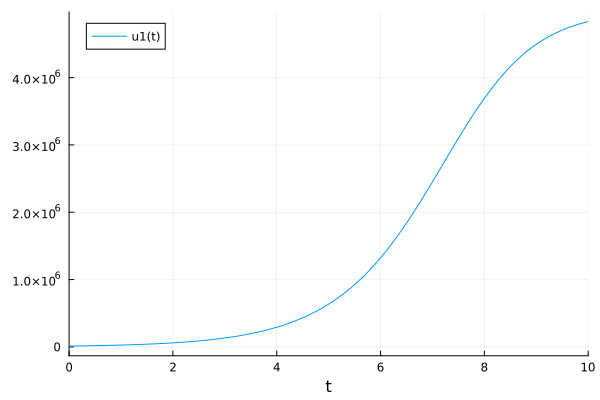

In [201]:
sol = solve(prob); 
plot(sol)

In [202]:
result5 = @time Optim.optimize(build_regularized_loss_func(0),
    [0.0, 2.0, 0.0], #upper and lower bounds for the optimization variables
    [5.0, 100000000.0, 1.0], ## bounds on constrains
    [0.01,10.0, 0.01], #initial values for optimization variables 
    Fminbox(LBFGS()),
    Optim.Options(f_tol=0.0, g_tol=1e-16, allow_f_increases=true, iterations=100000))

215.073579 seconds (733.47 M allocations: 42.449 GiB, 5.57% gc time, 0.39% compilation time: 11% of which was recompilation)


 * Status: success

 * Candidate solution
    Final objective value:     2.064541e+00

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 3.39e-05 ≰ 1.0e-16

 * Work counters
    Seconds run:   215  (vs limit Inf)
    Iterations:    13
    f(x) calls:    108605
    ∇f(x) calls:   108605


In [203]:
paramFIT5 = result5.minimizer

3-element Vector{Float64}:
      0.8989959109112152
 655819.1375134883
      0.27701700429558285

In [204]:
paramFitErr5 = result5.minimum

2.064540709868828

In [205]:
println("AIC of Logistic Fit: ", calcAICscore(paramFitErr5,size(data_t)[1],3))

AIC of Logistic Fit: 19.139926695706286


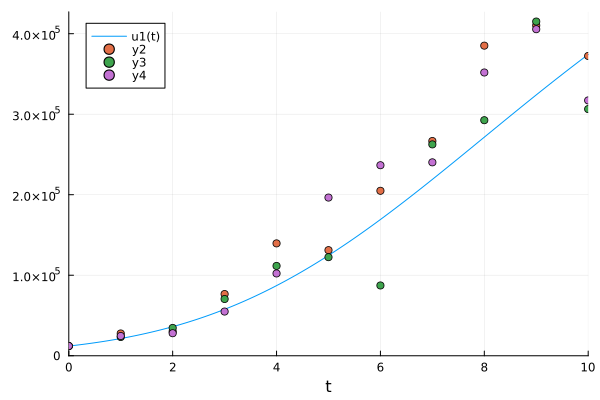

In [206]:
problem5 = ODEProblem(singleGenLogGrowth,u0,tspan,paramFIT5)
simFit5 = solve(problem5,Vern8());
plot(simFit5)
scatter!(timepts,repli1_t)
scatter!(timepts,repli2_t)
scatter!(timepts, repli3_t)

In [207]:
#export estimated curve to csv file
genlog_t = "C:/Users/adelpinoherrera/Dropbox (UFL)/research-share/Adriana/Pt-resistant Ovarian Cancer/Code/Pop dynamics T cells/est_genlog_t.csv"
CSV.write(genlog_t,simFit5)

"C:/Users/adelpinoherrera/Dropbox (UFL)/research-share/Adriana/Pt-resistant Ovarian Cancer/Code/Pop dynamics T cells/est_genlog_t.csv"